In [1]:
# Imports and plotting preferences

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import textalloc as ta

sns.set_theme(style='ticks',
              palette=sns.color_palette('Dark2'),
              font='Arial',
              rc={'figure.dpi': 300,
                  'figure.figsize':(7.2,4), # 7.2 inch is full page width
                  'axes.spines.right':False,
                  'axes.spines.top':False,
                  'font.size':7,
                  'xtick.labelsize':7,
                  'ytick.labelsize':7,
                  'axes.titlesize':7,
                  'axes.labelsize':7,
                  'legend.fontsize':7,
                  'legend.title_fontsize':7})

In [2]:
# Load pairing data from RNA secondary structure files
from functools import reduce

def lookup_pair(row):
  return paired[paired[:,0]==row['nt_site']][0,1]>0

structure_files = {
   'Lan2022_Vero':'../data/sars2-secondary-structure/Lan2022/41467_2022_28603_MOESM10_ESM.txt', # for secondary analysis
   'Lan2022_Huh7':'../data/sars2-secondary-structure/Lan2022/41467_2022_28603_MOESM11_ESM.txt', # higher quality than Vero per metrics in Lan et al
   'Huston2021':'../data/sars2-secondary-structure/Huston2021/SARS-CoV-2_Full_Length_Secondary_Structure_Map.ct', # from SHAPE data
   'Manfredonia2020':'../data/sars2-secondary-structure/Manfredonia2020/SARS-CoV-2.ct' # from SHAPE data
   }

paired_dicts = {}
dfs = []

for key in structure_files.keys():
  filename = structure_files[key]

  with open(filename) as f:
      lines = [line.rstrip().split() for line in f]

  paired = np.array([[int(x[0]),int(x[4])] for x in lines[1:]])

  basepaired = [ 1 if x>0 else 0 for x in paired[:,1] ]
  dfs.append(pd.DataFrame({'position':paired[:,0],key:basepaired}))

  paired_dicts[key] = dict(zip(paired[:,0], paired[:,1]))

structure_df = reduce(lambda  left,right: pd.merge(left,right,on='position',
                                            how='inner'), dfs)

In [3]:
# Load and process fitness data

ntmut = pd.read_csv('../data/mut-fitness/ntmut_fitness_all.csv')
dms_reactivity = pd.read_excel('../data/sars2-secondary-structure/Lan2022/41467_2022_28603_MOESM9_ESM.xlsx')

# primary analysis
paired_dict = paired_dicts['Lan2022_Huh7']

used_averaged_dms_reactivity = False # average Huh7 and Vero results optionally; increases bimodal nature of scatter plot for DMS vs mutational fitness

def lookup_wt_seq(row):
    return row.nt_mutation[0] == sars2_sequence[row.nt_site - 1]

def get_snp(row):

  nt1 = row.nt_mutation[0]
  if nt1 == 'T':
     nt1 = 'U'

  nt2 = row.nt_mutation[-1]
  if nt2 == 'T':
     nt2 = 'U'

  return nt1+nt2

def get_nt(row):

  nt = row.nt_mutation[0]
  if nt == 'T':
     nt = 'U'

  return nt

def lookup_pair(row):
  return paired_dict[row.nt_site]>0

def get_snp_type(row):

  if row.paired:
    snp_type = 'Basepaired '
  else:
    snp_type = 'Unpaired '

  return snp_type + row.snp[0] + '→' + row.snp[1]

ntmut['snp'] = ntmut.apply(get_snp,axis=1)
ntmut['nt'] = ntmut.apply(get_nt,axis=1)

ntmut['paired'] = ntmut.apply(lookup_pair,axis=1)
ntmut['SNP type'] = ntmut.apply(get_snp_type,axis=1)

# remove second order mutations
with open('../data/wuhan-hu-1.fa') as f:
    lines = [line.rstrip() for line in f]
sars2_sequence = ''.join(lines[1:])
ntmut['wt'] = ntmut.apply(lookup_wt_seq,axis=1)
ntmut = ntmut.query('wt==True').drop('wt',axis=1)

if used_averaged_dms_reactivity:
   dms_reactivity['avg_filtered'] = (dms_reactivity['Huh7 (filtered)'] + dms_reactivity['Vero (filtered)']) / 2
   ntmut = pd.merge(
      ntmut,dms_reactivity[['Genome coordinate','avg_filtered']],left_on='nt_site',right_on='Genome coordinate').drop(
         'Genome coordinate',axis=1).rename(columns={'avg_filtered':'DMS reactivity'})
else:
  ntmut = pd.merge(
      ntmut,dms_reactivity[['Genome coordinate','Huh7 (filtered)']],left_on='nt_site',right_on='Genome coordinate').drop(
      'Genome coordinate',axis=1).rename(columns={'Huh7 (filtered)':'DMS reactivity'})

# Replace zero and nan with pseudominimum reactivity at minimum measured level
pseudo_DMS = ntmut['DMS reactivity'][ntmut['DMS reactivity'] > 0].min() # minimum non-zero, non-nan value used to fill zeros and nan

ntmut['DMS reactivity'] = ntmut['DMS reactivity'].replace(0, pseudo_DMS) # Only relevant for plotting Fig 2
ntmut['DMS reactivity'] = ntmut['DMS reactivity'].fillna(pseudo_DMS) # This is acceptable where coverage is high

In [4]:
# For revision; how does correlation between basepairing and mutational fitness compare for different secondary structure predictions?

from scipy.stats import bootstrap, pointbiserialr, spearmanr

def boot_stat(x,y,axis=-1):
    return pointbiserialr(x,y,axis=axis)[0]

nboot=1000
keys = [k for k in structure_files.keys()]
keys.append('DMS reactivity')



print('Correlation between mutational fitness and basepairing and 95% CI for synonymous C→U')

mut_fit_struct = pd.merge(ntmut[['nt_site','delta_fitness','paired','synonymous','snp','DMS reactivity']].query('synonymous==True & snp=="CU"'),structure_df,left_on='nt_site',right_on='position',how='inner')

for key in keys:
    x = mut_fit_struct.delta_fitness
    y = mut_fit_struct[key]

    bs = np.zeros(nboot)

    for i in range(len(bs)):
        idx = np.random.choice(np.arange(len(x)), len(x), replace=True)

        if key == 'DMS reactivity':
            bs[i] = spearmanr(x[idx],y[idx]).statistic
        else:
            bs[i] = pointbiserialr(x[idx],-y[idx] + 1).statistic

    m = np.mean(bs)
    ci = np.percentile(bs,[2.5,97.5])
    print(f'{key}: {m:.2f} [{ci[0]:.2f},{ci[1]:.2f}]')

# sites with DMS above threshold
print('\nCorrelation between mutational fitness and basepairing and 95% CI for synonymous C→U only high DMS sites')

mut_fit_struct = pd.merge(ntmut[['nt_site','delta_fitness','paired','synonymous','snp','DMS reactivity']].query('synonymous==True & snp=="CU" & `DMS reactivity`>0.00012'),structure_df,left_on='nt_site',right_on='position',how='inner')

for key in keys:
    x = mut_fit_struct.delta_fitness
    y = -mut_fit_struct[key] + 1

    bs = np.zeros(nboot)

    for i in range(len(bs)):
        idx = np.random.choice(np.arange(len(x)), len(x), replace=True)

        if key == 'DMS reactivity':
            bs[i] = spearmanr(x[idx],-y[idx]).statistic
        else:
            bs[i] = pointbiserialr(x[idx],y[idx]).statistic

    m = np.mean(bs)
    ci = np.percentile(bs,[2.5,97.5])
    print(f'{key}: {m:.2f} [{ci[0]:.2f},{ci[1]:.2f}]')

# Comparing to non-syn C>U
print('\nCorrelation between mutational fitness and basepairing and 95% CI for nonsynonymous C→U')
mut_fit_struct = pd.merge(ntmut[['nt_site','delta_fitness','paired','synonymous','snp','DMS reactivity']].query('synonymous==False & snp=="CU"'),structure_df,left_on='nt_site',right_on='position',how='inner')

for key in keys:
    x = mut_fit_struct.delta_fitness
    y = -mut_fit_struct[key] + 1

    bs = np.zeros(nboot)

    for i in range(len(bs)):
        idx = np.random.choice(np.arange(len(x)), len(x), replace=True)
        
        if key == 'DMS reactivity':
            bs[i] = spearmanr(x[idx],-y[idx]).statistic
        else:
            bs[i] = pointbiserialr(x[idx],y[idx]).statistic

    m = np.mean(bs)
    ci = np.percentile(bs,[2.5,97.5])
    print(f'{key}: {m:.2f} [{ci[0]:.2f},{ci[1]:.2f}]')

Correlation between mutational fitness and basepairing and 95% CI for synonymous C→U
Lan2022_Vero: 0.63 [0.60,0.67]
Lan2022_Huh7: 0.59 [0.55,0.62]
Huston2021: 0.55 [0.50,0.59]
Manfredonia2020: 0.50 [0.46,0.53]
DMS reactivity: 0.45 [0.40,0.50]

Correlation between mutational fitness and basepairing and 95% CI for synonymous C→U only high DMS sites
Lan2022_Vero: 0.62 [0.58,0.66]
Lan2022_Huh7: 0.62 [0.58,0.67]
Huston2021: 0.54 [0.48,0.60]
Manfredonia2020: 0.49 [0.44,0.54]
DMS reactivity: 0.77 [0.74,0.79]

Correlation between mutational fitness and basepairing and 95% CI for nonsynonymous C→U
Lan2022_Vero: 0.16 [0.12,0.19]
Lan2022_Huh7: 0.18 [0.15,0.21]
Huston2021: 0.15 [0.12,0.18]
Manfredonia2020: 0.14 [0.10,0.17]
DMS reactivity: 0.13 [0.09,0.16]


/var/folders/5s/bxw093jd6wj429m_rr4h5yp80000gn/T/ipykernel_61541/2590781612.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels)


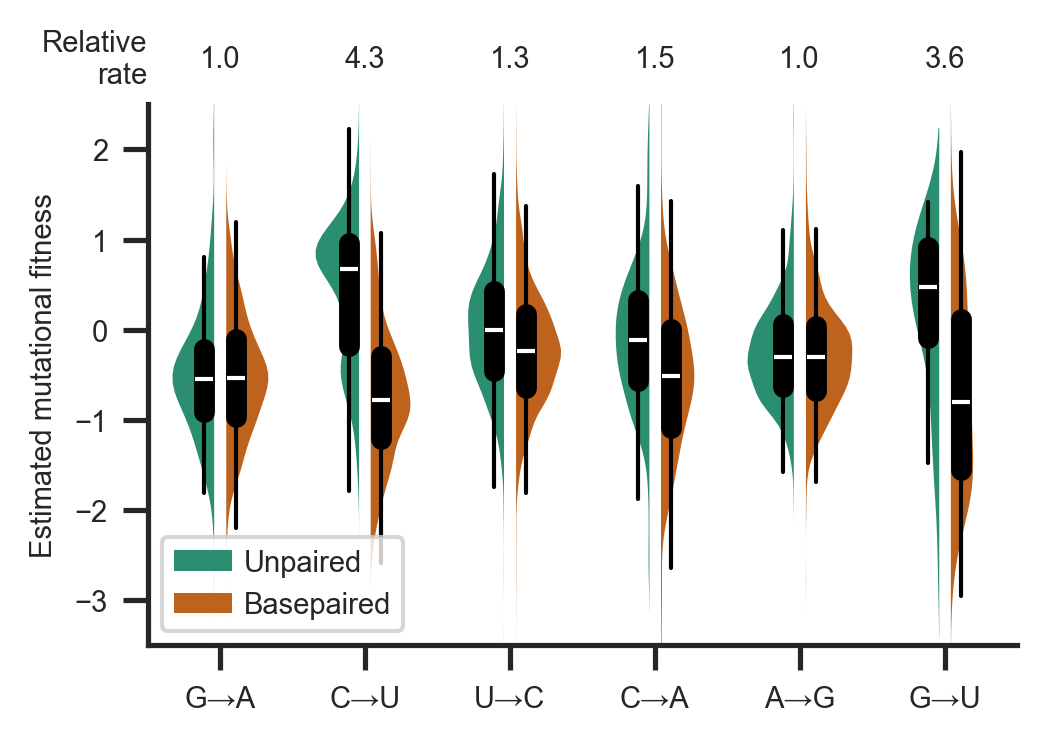

In [14]:
# Figure 1: Distributions of rates of common synonymous mutation by base pairing

def lookup_pair(row):
  return paired_dict[row.nt_site]>0

# PARAMETERS FOR ANALYSIS

limit_to = 'synonymous' # PRIMARY ANALYSIS
# limit_to = 'four_fold_degenerate' # an alternative analysis
# limit_to = 'noncoding' # another alternative

common_mutations = ['AG','CA','CU','GA','GU','UC']  # PRIMARY ANALYSIS
# common_mutations = list(ntmut.snp.unique())  # SECONDARY ANALYSIS

paired_dict = paired_dicts['Lan2022_Huh7'] # PRIMARY ANALYSIS
paired_dict = paired_dicts['Lan2022_Huh7'] # SECONDARY ANALYSIS

ntmut['paired'] = ntmut.apply(lookup_pair,axis=1)

plt.figure(figsize=(3.5,2.5)) # 3.5 inch for single column figure

ax = sns.violinplot(data=ntmut.query(limit_to + '==True & snp==@common_mutations'),x='snp',y='delta_fitness',hue='paired',split=True, gap=0.2,fill=True, linewidth=0,inner_kws=dict(box_width=5, whis_width=1, color="0"))
plt.ylim([-3.5,2.5])
plt.ylabel('Estimated mutational fitness')
plt.xlabel(None)

new_labels = {'False':'Unpaired','True':'Basepaired'}
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[new_labels[x] for x in previous_labels])
sns.move_legend(ax,'lower left',frameon=True,bbox_to_anchor=(0, 0),handletextpad=0.4)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = [x[0] + '→' + x[1] for x in labels]
ax.set_xticklabels(labels)

# updated for Nov 2024 mut-fitness data (calculated below)
diffs = {'G→A': 0.98,
         'C→U': 4.28,
         'U→C': 1.26,
         'C→A': 1.49,
         'A→G': 1.00,
         'G→U': 3.58}

ax.text(-0.5,3,'Relative\nrate',horizontalalignment='right',verticalalignment='center')
i = 0
for v in diffs.values():
  
  ax.text(i,3,f'{v:0.1f}',horizontalalignment='center',verticalalignment='center')
  i+=1

plt.tight_layout()

plt.savefig('../figures/Figure-1-fitness-and-secondary-structure.png')
plt.savefig('../figures/Figure-1-fitness-and-secondary-structure.svg')


Median fitness all synonymous:-0.46

Adjustment magnitude to normalize median mutational fitness:
SNP type	Adjustment	Fractional change in expected frequency
Basepaired C→U:	0.32	0.72
Unpaired C→U:	-1.13	3.10

Adjusted expected ration of unpaired vs basepaired synonymous C→U substitutions: 4.28

28.92% of nonsynoymous C→U sites lack DMS reactivity


<Figure size 2160x1200 with 0 Axes>

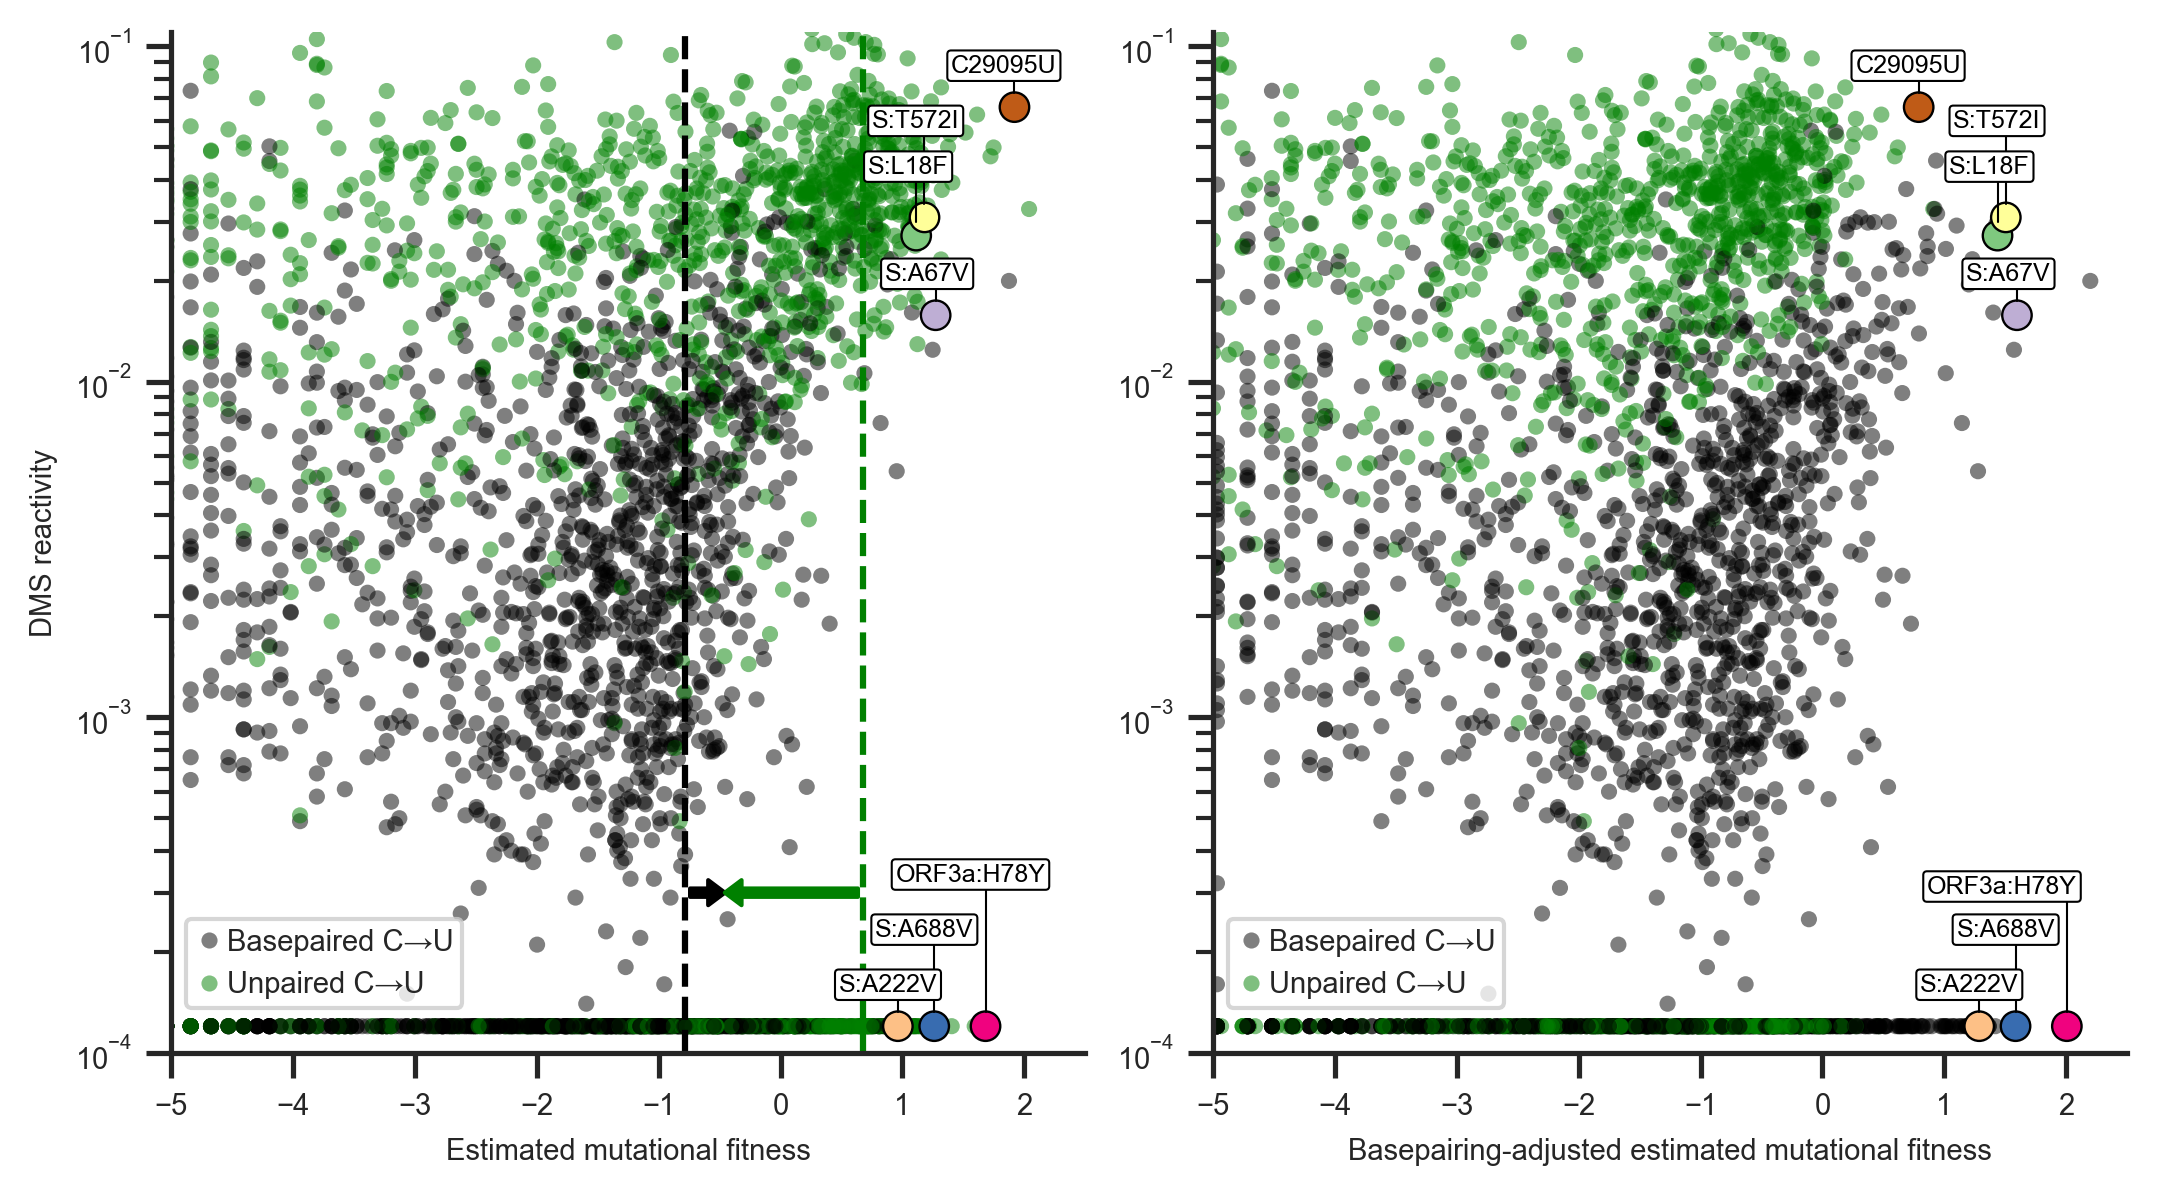

In [6]:
# Figure 2: Compare DMS reactivity to nonsynonymous mutational fitness before and after adjustment

plt.figure(figsize=(7.2,4))
xlim=[-5,2.5]
ylim=[1e-4,0.11]

fitness_adjust_threshold = 0.0 # PRIMARY analysis
# fitness_adjust_threshold = 0.02 # Unplanned analysis after seeing bimodal distribution and substantial noise in DMS data

# Estimate adjustment to paired and unpaired synonymous C>T required for median mutational fitnesses to match

if fitness_adjust_threshold>0:
    paired_ct_fitness = ntmut.query('snp=="CU" & '+limit_to+'==True & (paired==True | `DMS reactivity`<@fitness_adjust_threshold)')['delta_fitness'].to_numpy()
    unpaired_ct_fitness = ntmut.query('snp=="CU" & '+limit_to+'==True & paired==False & `DMS reactivity`>=@fitness_adjust_threshold')['delta_fitness'].to_numpy()
else:
    paired_ct_fitness = ntmut.query('snp=="CU" & '+limit_to+'==True & paired==True')['delta_fitness'].to_numpy()
    unpaired_ct_fitness = ntmut.query('snp=="CU" & '+limit_to+'==True & paired==False')['delta_fitness'].to_numpy()

all_ct_fitness = np.concatenate((paired_ct_fitness,unpaired_ct_fitness))

medPaired = np.median(paired_ct_fitness)
medUnpaired = np.median(unpaired_ct_fitness)
medAll = np.median(all_ct_fitness)
a = medAll - medPaired
b = medAll - medUnpaired

# Print result
print(f'\nMedian fitness all synonymous:%0.2f'%medAll)
print('\nAdjustment magnitude to normalize median mutational fitness:')
print('SNP type','Adjustment','Fractional change in expected frequency',sep='\t')
print('Basepaired C→U:',f'%.2f'%a,f'%.2f'%np.exp(-a),sep='\t')
print('Unpaired C→U:',f'%.2f'%b,f'%.2f'%np.exp(-b),sep='\t')

print('\nAdjusted expected ration of unpaired vs basepaired synonymous C→U substitutions:',f'%.2f'%np.exp(a-b))

ntmut.loc[(ntmut['snp']=='CU')&((ntmut['paired']==True) | (ntmut['DMS reactivity']<fitness_adjust_threshold)),'adjusted_fitness'] = ntmut.query('(`DMS reactivity`<@fitness_adjust_threshold | paired==True) & snp=="CU"').delta_fitness + a
ntmut.loc[(ntmut['snp']=='CU')&(ntmut['paired']==False)&(ntmut['DMS reactivity']>=fitness_adjust_threshold),'adjusted_fitness'] = ntmut.query('`DMS reactivity`>@fitness_adjust_threshold & paired==False & snp=="CU"').delta_fitness + b

min_dms = ntmut['DMS reactivity'].min()
n = len(ntmut.query('snp=="CU" & synonymous==False & `DMS reactivity`==@min_dms'))
N = len(ntmut.query('snp=="CU" & synonymous==False'))
print('\n' + f'%.2f'%(100.0*n/N) + '% of nonsynoymous C→U sites lack DMS reactivity')

sites_of_interest = np.array([25624,21762,23625,21614,23277,22227,29095])
site_labels = np.array(['ORF3a:H78Y','S:A67V','S:A688V','S:L18F','S:T572I','S:A222V','C29095U'])
idx = np.argsort(sites_of_interest)
sites_of_interest = list(sites_of_interest[idx])
site_labels = list(site_labels[idx])

for i in range(len(sites_of_interest)):
    ntmut.loc[(ntmut.nt_site==sites_of_interest[i])&(ntmut.snp=="CU"),"Mutation"] = site_labels[i]

fig = plt.figure(figsize=(7.2,4))

plt.subplot(1,2,1)
ax1 = sns.scatterplot(data=ntmut.query('snp==["CU"] & synonymous==False'),y='DMS reactivity',x='delta_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→U':'k', 'Unpaired C→U':'g' })
plt.xlabel('Estimated mutational fitness')
sns.scatterplot(ax=ax1,data=ntmut.query('snp==["CU"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='delta_fitness',hue='Mutation',edgecolors='k',s=50,alpha=1,palette=sns.color_palette('Accent',len(sites_of_interest)),legend=False)

ax1.axvline(medPaired,color='k',linestyle='--')
ax1.axvline(medUnpaired,color='g',linestyle='--')

plt.xlim(xlim)
plt.ylim(ylim)
# ax1.arrow(medPaired,3e-4,medAll-medPaired,0,transform=ax1.transAxes, length_includes_head=True, color='r')
ax1.annotate('', xy=(medAll, 3e-4), xytext=(medPaired, 3e-4), 
            arrowprops=dict(color='black', shrink=0.,width=2,headwidth=6,headlength=4) #, width=0.5, headwidth=0.5, headlength=0.5),
            )

ax1.annotate('', xy=(medAll, 3e-4), xytext=(medUnpaired, 3e-4), 
            arrowprops=dict(color='green', shrink=0.,width=2,headwidth=6,headlength=4) #, width=0.5, headwidth=0.5, headlength=0.5),
            )

plt.yscale('log')

legend = ax1.legend(loc='lower left', bbox_to_anchor=(0, 0.03),markerfirst=True,handletextpad=0.1,frameon=True,borderpad=0.3,handlelength=1)

x =  ntmut.query('snp==["CU"] & nt_site==@sites_of_interest').sort_values('nt_site')[['delta_fitness','DMS reactivity']].to_numpy()
ta.allocate_text(fig,ax1,x[:,0],1.1*x[:,1],
                site_labels,
                x_scatter = 0.05+x[:,0],
                y_scatter = 1.1*x[:,1],
                textsize=6,
                y_logscale_base=10,
                avoid_label_lines_overlap=False,
                margin=0.01,
                min_distance=0.015,
                direction='north',
                nbr_candidates=1000,
                linecolor='k',
                linewidth=0.5)

plt.setp(ax1.texts,va='center',bbox=dict(facecolor='w', edgecolor='k', alpha=1,linewidth=0.5,boxstyle='round,pad=0.15'))

plt.subplot(1,2,2)
ax2 = sns.scatterplot(data=ntmut.query('snp==["CU"] & synonymous==False'),y='DMS reactivity',x='adjusted_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→U':'k', 'Unpaired C→U':'g' })
plt.xlabel('Basepairing-adjusted estimated mutational fitness')
sns.scatterplot(ax=ax2,data=ntmut.query('snp==["CU"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='adjusted_fitness',edgecolors='k',s=50,alpha=1,hue='Mutation',palette=sns.color_palette('Accent',len(sites_of_interest)),legend=False)
plt.xlim(xlim)
plt.ylim(ylim)
plt.ylabel('')
plt.yscale('log')
legend = ax2.legend(loc='lower left', bbox_to_anchor=(0, 0.03),markerfirst=True,handletextpad=0.1,frameon=True,borderpad=0.3,handlelength=1)

x =  ntmut.query('snp==["CU"] & nt_site==@sites_of_interest')[['adjusted_fitness','DMS reactivity']].to_numpy()
ta.allocate_text(fig,ax2,x[:,0],1.1*x[:,1],
                site_labels,
                x_scatter = 0.05+x[:,0],
                y_scatter = 1.1*x[:,1],
                textsize=6,
                y_logscale_base=10,
                avoid_label_lines_overlap=False,
                margin=0.01,
                min_distance=0.015,
                direction='north',
                nbr_candidates=1000,
                linecolor='k',
                linewidth=0.5,
                seed=1)

plt.setp(ax2.texts,va='center',bbox=dict(facecolor='w', edgecolor='k', alpha=1,linewidth=0.5,boxstyle='round,pad=0.15'))

plt.tight_layout()

plt.savefig('../figures/Figure-2-fitness-and-secondary-structure.png')
plt.savefig('../figures/Figure-2-fitness-and-secondary-structure.svg')

Correlation between mutational fitness and basepairing and 95% CI for synonymous C→U after adjustment
Lan2022_Vero: -0.13 [-0.18,-0.08]
Lan2022_Huh7: 0.18 [0.13,0.22]
Huston2021: -0.08 [-0.13,-0.03]
Manfredonia2020: -0.06 [-0.11,-0.01]
DMS reactivity: 0.18 [0.13,0.22]


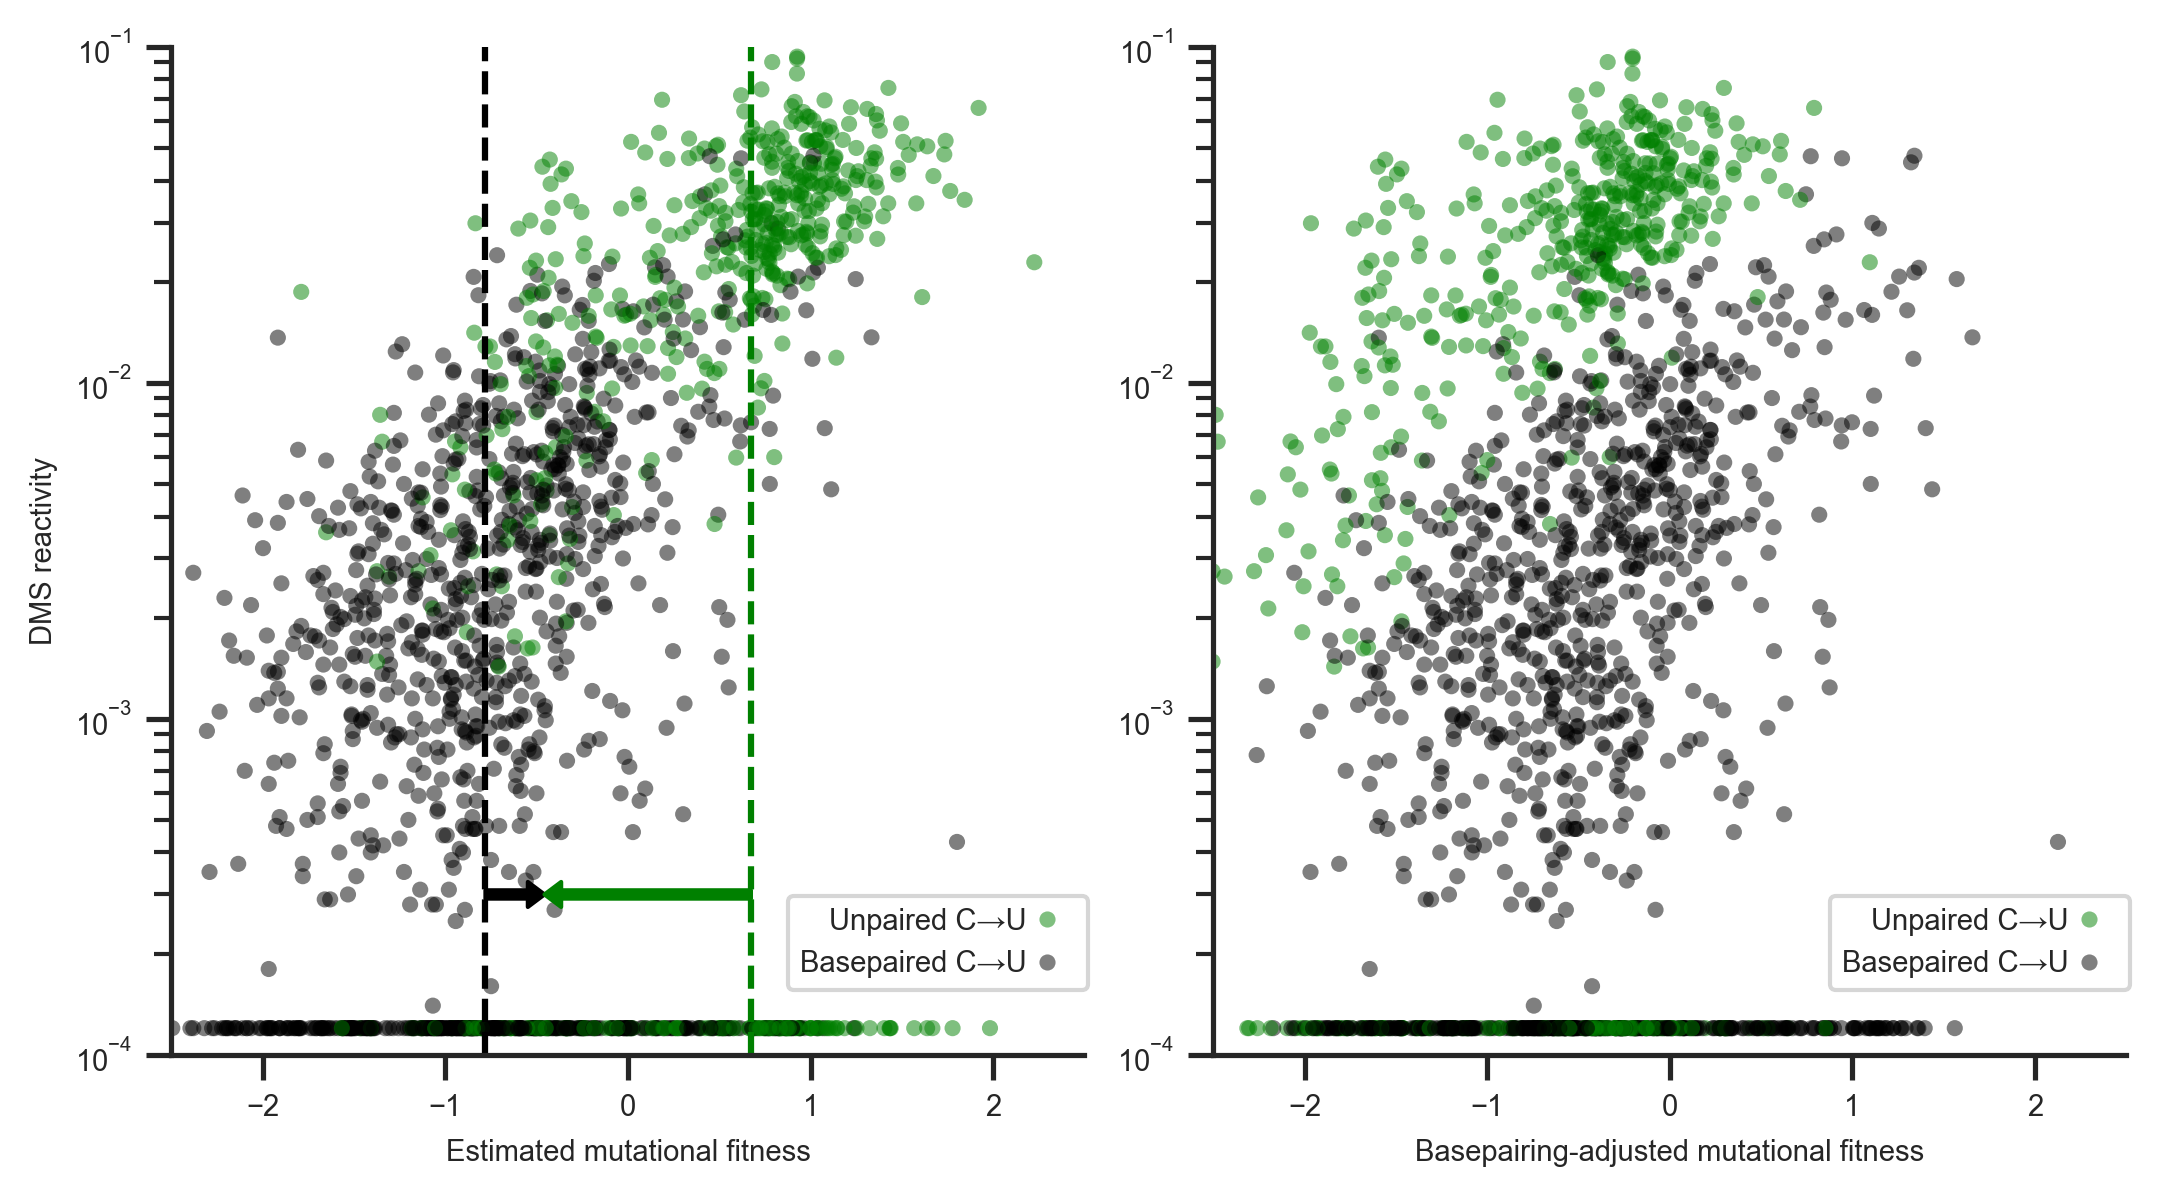

In [7]:
# For revision -- illustrate adjustment with synonymous mutations

from scipy.stats import bootstrap, pointbiserialr, spearmanr

nboot=1000
keys = [k for k in structure_files.keys()]
keys.append('DMS reactivity')

print('Correlation between mutational fitness and basepairing and 95% CI for synonymous C→U after adjustment')

mut_fit_struct = pd.merge(ntmut[['nt_site','adjusted_fitness','paired','synonymous','snp','DMS reactivity']].query('synonymous==True & snp=="CU"'),structure_df,left_on='nt_site',right_on='position',how='inner')

for key in keys:
    x = mut_fit_struct.adjusted_fitness
    y = mut_fit_struct[key]

    bs = np.zeros(nboot)

    for i in range(len(bs)):
        idx = np.random.choice(np.arange(len(x)), len(x), replace=True)

        if key == 'DMS reactivity':
            bs[i] = spearmanr(x[idx],y[idx]).statistic
        else:
            bs[i] = pointbiserialr(x[idx],y[idx]).statistic

    m = np.mean(bs)
    ci = np.percentile(bs,[2.5,97.5])
    print(f'{key}: {m:.2f} [{ci[0]:.2f},{ci[1]:.2f}]')

# Synonymous mutation equivalent of Figure 2

plt.figure(figsize=(7.2,4))
xlim=[-2.5,2.5]
ylim=[1e-4,0.1]


plt.subplot(1,2,1)
ax1 = sns.scatterplot(data=ntmut.query('snp==["CU"] & synonymous==True'),y='DMS reactivity',x='delta_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→U':'k', 'Unpaired C→U':'g' })
plt.xlabel('Estimated mutational fitness')
plt.xlim(xlim)
plt.ylim(ylim)

ax1.axvline(medPaired,color='k',linestyle='--')
ax1.axvline(medUnpaired,color='g',linestyle='--')

plt.xlim(xlim)
plt.ylim(ylim)

ax1.annotate('', xy=(medAll, 3e-4), xytext=(medPaired, 3e-4), 
            arrowprops=dict(color='black', shrink=0.,width=2,headwidth=6,headlength=4) #, width=0.5, headwidth=0.5, headlength=0.5),
            )

ax1.annotate('', xy=(medAll, 3e-4), xytext=(medUnpaired, 3e-4), 
            arrowprops=dict(color='green', shrink=0.,width=2,headwidth=6,headlength=4) #, width=0.5, headwidth=0.5, headlength=0.5),
            )

plt.yscale('log')

legend = ax1.legend(loc='lower right', bbox_to_anchor=(1.02, 0.05),markerfirst=False,handletextpad=-0.3,frameon=True)

plt.subplot(1,2,2)
ax2 = sns.scatterplot(data=ntmut.query('snp==["CU"] & synonymous==True'),y='DMS reactivity',x='adjusted_fitness',hue='SNP type',s=15,linewidth=0,alpha=0.5, palette={'Basepaired C→U':'k', 'Unpaired C→U':'g' })
plt.xlabel('Basepairing-adjusted mutational fitness')
# sns.scatterplot(ax=ax2,data=ntmut.query('snp==["CU"] & nt_site==@sites_of_interest'),y='DMS reactivity',x='adjusted_fitness',hue='Mutation',edgecolors='k',s=50,alpha=1,palette=sns.color_palette('Accent',len(sites_of_interest)))
plt.xlim(xlim)
plt.ylim(ylim)
plt.yscale('log')
legend = ax2.legend(loc='lower right', bbox_to_anchor=(1.02, 0.05),markerfirst=False,handletextpad=-0.3,frameon=True)
plt.ylabel('')

plt.tight_layout()

plt.savefig('../figures/Figure-S1-synonymous-fitness-and-secondary-structure.png')
plt.savefig('../figures/Figure-S1-synonymous-fitness-and-secondary-structure.svg')


In [83]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.multitest import multipletests

# PARAMETERS

# tested_mutations = common_mutations # PRIMARY ANALYSIS
tested_mutations = ntmut.snp.unique() # SECONDARY ANALYSIS

p_values = []

# Collect all p-values from the comparisons
for snp in tested_mutations:
    df_subset = ntmut.query('snp == @snp & ' + limit_to + ' == True')
    tukey_result = pairwise_tukeyhsd(df_subset['delta_fitness'], df_subset['paired'], alpha=0.05)
    p_values.append(tukey_result.pvalues[0])

    # print(snp)
    # print(tukey_result)

# Correct all p-values collected for multiple testing
corrected_p_values = multipletests(p_values, alpha=0.05, method='bonferroni')

# Output the corrected p-values
print("Corrected p-values for multiple testing:")

print('SNP','Median change in relative fitness','p value','significant p<0.05',sep='\t')

for i in range(len(tested_mutations)):
    
    diff = ntmut.query('snp == @tested_mutations[@i] & ' + limit_to + ' == True')[['delta_fitness','paired']].groupby('paired').median().to_numpy()
    diff = diff[0]-diff[1]

    print(tested_mutations[i],f'%.3E'%diff[0],f'%.3E' % corrected_p_values[1][i],corrected_p_values[1][i]<0.05,sep='\t')

Corrected p-values for multiple testing:
SNP	Median change in relative fitness	p value	significant p<0.05
AC	0.000E+00	1.000E+00	False
AG	0.000E+00	1.000E+00	False
AU	3.695E-01	4.284E-07	True
UA	0.000E+00	4.156E-01	False
UC	2.307E-01	0.000E+00	True
UG	0.000E+00	3.974E-01	False
GA	-1.777E-02	1.000E+00	False
GC	1.266E+00	5.008E-09	True
GU	1.275E+00	5.112E-08	True
CA	3.997E-01	9.730E-10	True
CG	9.555E-01	0.000E+00	True
CU	1.454E+00	0.000E+00	True


In [9]:
# tukey w/ adjustment for all snp + pair types simultaneously
# Taking hundreds of possible comparisons into account, still the same ones are significant

from statsmodels.stats.multicomp import pairwise_tukeyhsd

df_subset = ntmut.query(limit_to + ' == True')
tukey_result = pairwise_tukeyhsd(df_subset['delta_fitness'], df_subset['SNP type'], alpha=0.05)
print(tukey_result)

/Users/zach/miniconda3/envs/datascience/lib/python3.12/site-packages/scipy/integrate/_quadpack_py.py:1272: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


        Multiple Comparison of Means - Tukey HSD, FWER=0.05         
    group1         group2     meandiff p-adj   lower   upper  reject
--------------------------------------------------------------------
Basepaired A→C Basepaired A→G   0.3607    0.0  0.2031  0.5183   True
Basepaired A→C Basepaired A→U  -0.3609    0.0 -0.5381 -0.1837   True
Basepaired A→C Basepaired C→A   0.0962 0.9887 -0.1041  0.2965  False
Basepaired A→C Basepaired C→G  -1.2793    0.0 -1.4919 -1.0667   True
Basepaired A→C Basepaired C→U  -0.1051 0.7674 -0.2661  0.0559  False
Basepaired A→C Basepaired G→A   0.1169  0.788 -0.0646  0.2984  False
Basepaired A→C Basepaired G→C  -0.7475    0.0 -1.0153 -0.4796   True
Basepaired A→C Basepaired G→U   -0.068    1.0 -0.3358  0.1999  False
Basepaired A→C Basepaired U→A  -0.2027 0.0004  -0.357 -0.0485   True
Basepaired A→C Basepaired U→C   0.4213    0.0   0.281  0.5617   True
Basepaired A→C Basepaired U→G  -0.1526 0.0714 -0.3099  0.0048  False
Basepaired A→C   Unpaired A→C   0.

In [10]:
# Can get the same result with fitting ols model with interaction terms

from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd, MultiComparison

result = ols('delta_fitness ~ C(snp,Treatment("CU"))*C(paired,Treatment(True))', data=ntmut.query('synonymous==True')).fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:          delta_fitness   R-squared:                       0.153
Model:                            OLS   Adj. R-squared:                  0.152
Method:                 Least Squares   F-statistic:                     147.2
Date:                Fri, 22 Nov 2024   Prob (F-statistic):               0.00
Time:                        14:42:17   Log-Likelihood:                -25892.
No. Observations:               18810   AIC:                         5.183e+04
Df Residuals:                   18786   BIC:                         5.202e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                                                                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------

In [15]:
# How much does C>T median in unpaired being 1.45 and G>T 1.28 in paired correspond to frequency increase?
#   Answer: roughly 4x more frequently unpaired vs paired for both

# Corrected p-values for multiple testing:
# SNP	Median change in relative fitness	p value	significant p<0.05
# AG	0.000E+00	1.000E+00	False
# CA	3.997E-01	4.865E-10	True
# CU	1.454E+00	0.000E+00	True
# GA	-1.777E-02	1.000E+00	False
# GU	1.275E+00	2.556E-08	True
# UC	2.307E-01	0.000E+00	True

diffs = {'G→A':-1.777E-02,
         'C→U':1.454E+00,
         'U→C':2.307E-01,
         'C→A':3.997E-01,
         'A→G':0.000E+00,
         'G→U':1.275E+00}

for snp in diffs.keys():
    print(snp,f'%.2f'%np.exp(diffs[snp]))

G→A 0.98
C→U 4.28
U→C 1.26
C→A 1.49
A→G 1.00
G→U 3.58


In [16]:
# The most unfavorable synonymous mutations indicate conservation beyond annotated reading frames
# FSE is very common in this list and can be mentioned in the revision
# The list also includes TRS-proximal sequences
# Importance of Env circa 26343 is unclear (to me based on a preliminary literature search; possibly related to a non-canonical sgRNA junction)
ntmut.sort_values('adjusted_fitness',ascending=True).query('synonymous==True')[0:20]

,nt_site,nt_mutation,gene,noncoding,synonymous,four_fold_degenerate,expected_count,actual_count,count_terminal,count_non_terminal,mean_log_size,delta_fitness,snp,nt,paired,SNP type,DMS reactivity,adjusted_fitness,Mutation
77933,26343,C26343T,E,False,True,False,696.89,3,3,0,0.00000,-5.2946,CU,C,False,Unpaired C→U,0.00587,-6.42516,nan
39587,13509,C13509T,ORF1ab,False,True,True,696.89,1,1,0,0.00000,-6.1419,CU,C,True,Basepaired C→U,0.00142,-5.81847,nan
39533,13491,C13491T,ORF1ab,False,True,True,696.89,4,4,0,0.00000,-5.0433,CU,C,True,Basepaired C→U,0.00355,-4.71987,nan
87662,29603,C29603T,ORF10,False,True,False,696.89,13,11,2,0.13783,-3.9447,CU,C,True,Basepaired C→U,0.00012,-3.62127,nan
81251,27450,C27450T,ORF7a,False,True,False,696.89,116,64,52,0.62916,-1.7895,CU,C,False,Unpaired C→U,0.01865,-2.92006,nan
74255,25114,C25114T,S,False,True,False,696.89,133,80,53,0.65384,-1.6532,CU,C,False,Unpaired C→U,0.00359,-2.78376,nan
81155,27418,C27418T,ORF7a,False,True,False,696.89,145,92,53,0.54205,-1.5672,CU,C,False,Unpaired C→U,0.00012,-2.69776,nan
52694,17898,C17898T,ORF1ab,False,True,False,696.89,160,95,65,0.56138,-1.4691,CU,C,False,Unpaired C→U,0.00012,-2.59966,nan
82322,27812,C27812T,ORF7b,False,True,False,696.89,170,102,68,0.62776,-1.4086,CU,C,False,Unpaired C→U,0.00012,-2.53916,nan
82226,27779,C27779T,ORF7b,False,True,False,696.89,176,103,73,0.67558,-1.3740,CU,C,False,Unpaired C→U,0.00275,-2.50456,nan


5′ nt	Paired	Median	95% low	95% high
A	True	-0.77	-0.84	-0.65
G	True	-0.87	-0.91	-0.78
C	True	-0.70	-0.80	-0.59
U	True	-0.79	-0.90	-0.64
A	False	0.55	0.45	0.68
G	False	0.15	0.01	0.50
C	False	0.57	0.33	0.69
U	False	0.83	0.77	0.88


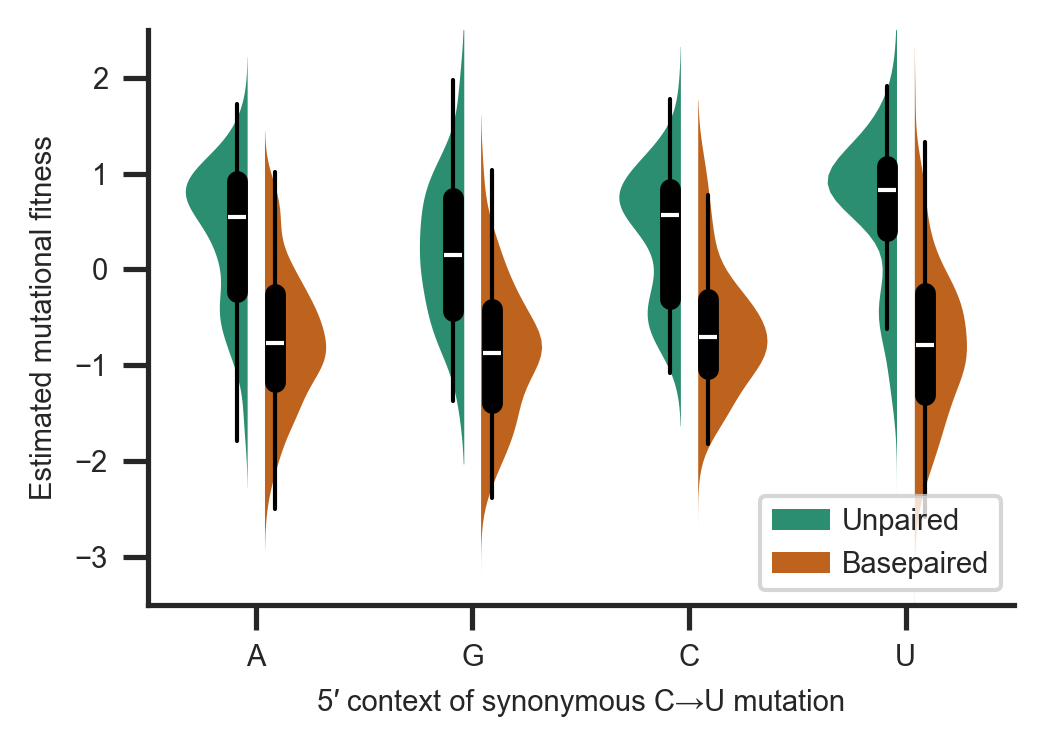

In [81]:
# check out 5' context

ntmut['5pContext'] = ntmut.apply(lambda x: sars2_sequence[x.nt_site-2],axis=1)
ntmut.loc[ntmut['5pContext']=='T','5pContext'] = 'U'

plt.figure(figsize=(3.5,2.5)) # 3.5 inch for single column figure

ax = sns.violinplot(data=ntmut.query('synonymous==True & snp=="CU"'),x='5pContext',y='delta_fitness',hue='paired',split=True, gap=0.2,fill=True, linewidth=0,inner_kws=dict(box_width=5, whis_width=1, color="0"),order=['A','G','C','U'])
plt.ylim([-3.5,2.5])
plt.ylabel('Estimated mutational fitness')
plt.xlabel('5′ context of synonymous C→U mutation')

new_labels = {'False':'Unpaired','True':'Basepaired'}
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[new_labels[x] for x in previous_labels])
sns.move_legend(ax,'lower left',frameon=True,bbox_to_anchor=(0.69, 0),handletextpad=0.4)

plt.tight_layout()

plt.savefig('../figures/Figure-S2-cu-fitness-5p-context.png')
plt.savefig('../figures/Figure-S2-cu-fitness-5p-context.svg')

# 95% CIs of 5' context analysis for synonymous C>U

from scipy.stats import bootstrap

print(f'5′ nt\tPaired\tMedian\t95% low\t95% high')
for bp in [True, False]:
    for nt in 'AGCU':
        x = ntmut.query(f'`5pContext`=="{nt}" & paired=={bp} & synonymous & snp=="CU"').delta_fitness.to_numpy()
        res = bootstrap((x,), np.median, axis=-1, confidence_level=0.95, n_resamples=1000)
        ci_l, ci_u = res.confidence_interval
        print(f'{nt}\t{bp}\t{np.median(x):.2f}\t{ci_l:.2f}\t{ci_u:.2f}')
# ntmut

3′ nt	Paired	Median	95% low	95% high
A	True	-0.83	-0.89	-0.75
G	True	-0.24	-0.35	-0.09
C	True	-0.72	-0.85	-0.59
U	True	-0.88	-0.94	-0.80
A	False	0.75	0.67	0.82
G	False	1.00	0.77	1.10
C	False	0.16	-0.19	0.33
U	False	0.59	0.48	0.70


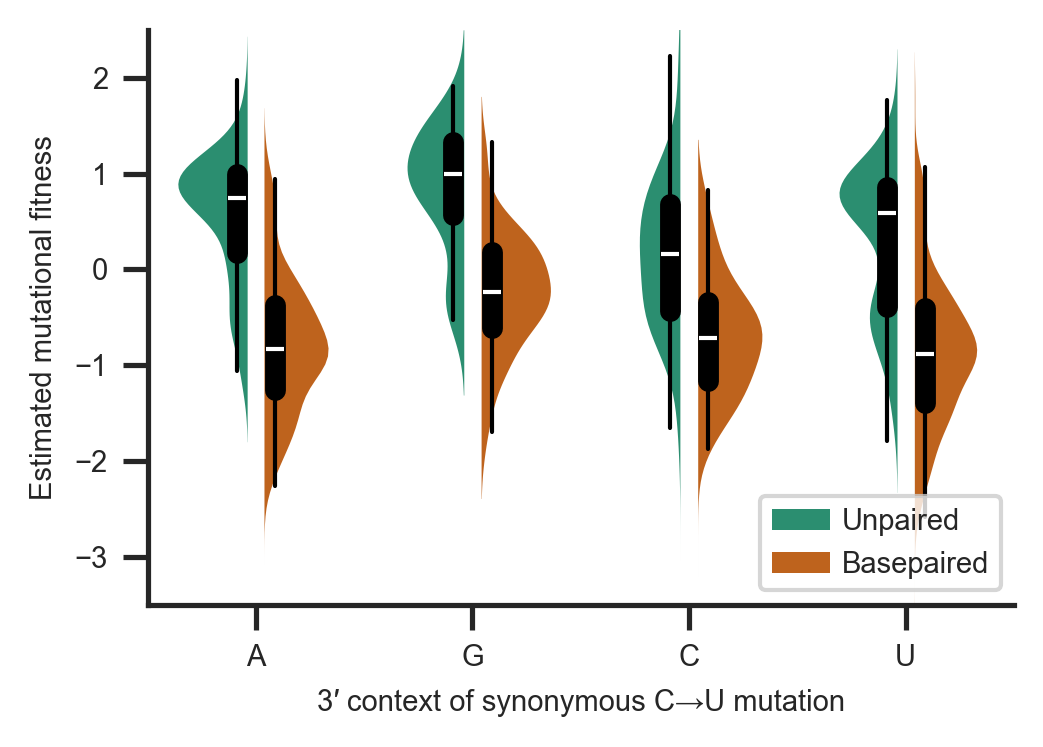

In [82]:
# check out 3' context

ntmut['3pContext'] = ntmut.apply(lambda x: sars2_sequence[x.nt_site],axis=1)
ntmut.loc[ntmut['3pContext']=='T','3pContext'] = 'U'

plt.figure(figsize=(3.5,2.5)) # 3.5 inch for single column figure

ax = sns.violinplot(data=ntmut.query('synonymous==True & snp=="CU"'),x='3pContext',y='delta_fitness',hue='paired',split=True, gap=0.2,fill=True, linewidth=0,inner_kws=dict(box_width=5, whis_width=1, color="0"),order=['A','G','C','U'])
plt.ylim([-3.5,2.5])
plt.ylabel('Estimated mutational fitness')
plt.xlabel('3′ context of synonymous C→U mutation')

new_labels = {'False':'Unpaired','True':'Basepaired'}
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[new_labels[x] for x in previous_labels])
sns.move_legend(ax,'lower left',frameon=True,bbox_to_anchor=(0.69, 0),handletextpad=0.4)

plt.tight_layout()

plt.savefig('../figures/Figure-S3-cu-fitness-3p-context.png')
plt.savefig('../figures/Figure-S3-cu-fitness-3p-context.svg')

# 95% CIs of 3' context analysis for synonymous C>U

from scipy.stats import bootstrap

print(f'3′ nt\tPaired\tMedian\t95% low\t95% high')
for bp in [True, False]:
    for nt in 'AGCU':
        x = ntmut.query(f'`3pContext`=="{nt}" & paired=={bp} & synonymous & snp=="CU"').delta_fitness.to_numpy()
        res = bootstrap((x,), np.median, axis=-1, confidence_level=0.95, n_resamples=1000)
        ci_l, ci_u = res.confidence_interval
        print(f'{nt}\t{bp}\t{np.median(x):.2f}\t{ci_l:.2f}\t{ci_u:.2f}')
# ntmut

,nt_site,nt_mutation,gene,noncoding,synonymous,four_fold_degenerate,expected_count,actual_count,count_terminal,count_non_terminal,...,snp,nt,paired,SNP type,DMS reactivity,adjusted_fitness,Mutation,5pContext,3pContext,5pPaired
0,266,A266C,ORF1a;ORF1ab,False,False,False,11.350,0,0,0,...,AC,A,True,Basepaired A→C,0.00372,NaN,nan,G,U,True
1,266,A266G,ORF1a;ORF1ab,False,False,False,89.169,0,0,0,...,AG,A,True,Basepaired A→G,0.00372,NaN,nan,G,U,True
2,266,A266T,ORF1a;ORF1ab,False,False,False,25.461,0,0,0,...,AU,A,True,Basepaired A→U,0.00372,NaN,nan,G,U,True
3,267,T267A,ORF1a;ORF1ab,False,False,False,17.508,1,1,0,...,UA,U,True,Basepaired U→A,0.00012,NaN,nan,A,G,True
4,267,T267C,ORF1a;ORF1ab,False,False,False,82.096,0,0,0,...,UC,U,True,Basepaired U→C,0.00012,NaN,nan,A,G,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87871,29673,A29673G,noncoding,True,False,False,89.169,14,8,6,...,AG,A,True,Basepaired A→G,0.00012,NaN,nan,U,G,True
87872,29673,A29673T,noncoding,True,False,False,25.461,10,6,4,...,AU,A,True,Basepaired A→U,0.00012,NaN,nan,U,G,True
87873,29674,G29674A,noncoding,True,False,False,192.690,94,58,36,...,GA,G,True,Basepaired G→A,0.00012,NaN,nan,A,C,True
87874,29674,G29674C,noncoding,True,False,False,22.683,11,8,3,...,GC,G,True,Basepaired G→C,0.00012,NaN,nan,A,C,True


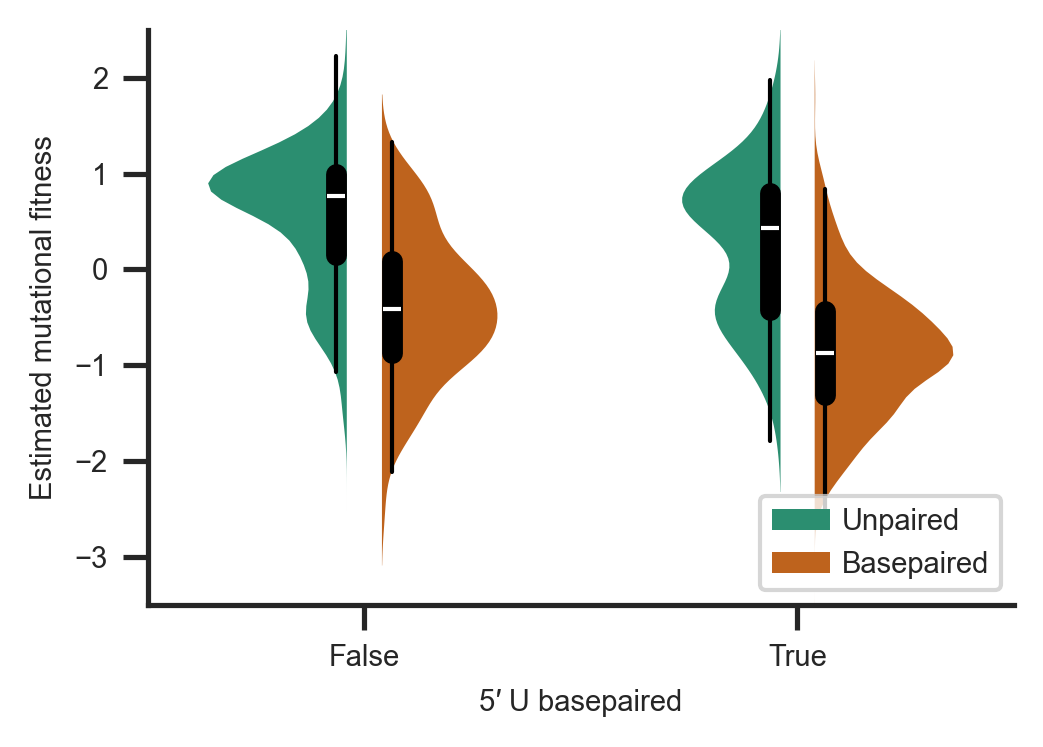

In [134]:
# check out 5' U when paired or unpaired 5'

def lookup_pair(row):
  return paired[paired[:,0]==row['nt_site']-1][0,1]>0

ntmut['5pContext'] = ntmut.apply(lambda x: sars2_sequence[x.nt_site-2],axis=1)
ntmut.loc[ntmut['5pContext']=='T','5pContext'] = 'U'

ntmut['5pPaired'] = ntmut.apply(lookup_pair,axis=1)

plt.figure(figsize=(3.5,2.5)) # 3.5 inch for single column figure

ax = sns.violinplot(data=ntmut.query('synonymous==True & snp=="CU"'),x='5pPaired',y='delta_fitness',hue='paired',split=True, gap=0.2,fill=True, linewidth=0,inner_kws=dict(box_width=5, whis_width=1, color="0"))
plt.ylim([-3.5,2.5])
plt.ylabel('Estimated mutational fitness')
plt.xlabel('5′ U basepaired')

new_labels = {'False':'Unpaired','True':'Basepaired'}
handles, previous_labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=[new_labels[x] for x in previous_labels])
sns.move_legend(ax,'lower left',frameon=True,bbox_to_anchor=(0.69, 0),handletextpad=0.4)

plt.tight_layout()
ntmut

In [28]:
# top rank paired, non-synonymous CT
print(ntmut.query('synonymous==False & snp==["CU"] & paired==True')[['nt_mutation','delta_fitness','DMS reactivity']].sort_values('delta_fitness',ascending=False)[0:15].to_string(index=False))

nt_mutation  delta_fitness  DMS reactivity
     C3096T        1.86100         0.01997
    C25624T        1.50000         0.00012
    C23625T        1.27390         0.00012
    C21762T        1.26880         0.01578
    C12459T        1.24930         0.01245
    C25613T        1.21770         0.00012
    C23277T        1.14010         0.03088
    C29358T        1.10090         0.02950
    C20233T        1.08890         0.00012
    C21614T        1.06870         0.02725
     C6636T        1.06000         0.00012
    C18377T        1.02240         0.00012
    C26060T        0.99260         0.00012
    C22227T        0.96368         0.00012
     C7926T        0.95152         0.00012


In [17]:
# frequency of pairing for common SNPs

snps = ['AG','CU','GU','UC']

for snp in snps:
  p = np.sum(ntmut.query('snp==@snp').paired == True)
  u = np.sum(ntmut.query('snp==@snp').paired == False)
  frac = p / (u+p)
  print(snp,f'%.2f' % frac + '%')

AG 0.46%
CU 0.60%
GU 0.73%
UC 0.53%


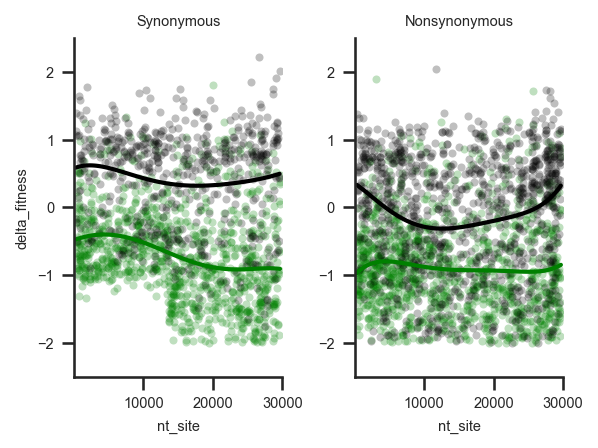

In [92]:
#  Example whether pair:unpaired difference is constant along genome; arbitrary polynomial regression for visualization

min_delta_fitness_to_consider = -2.0 # otherwise very, very low mutational fitness for some NS adds too much noise
ylim = [-2.5,2.5]
# plot along the chromosome synonymous C>T
plt.figure(figsize=(4,3))
plt.subplot(1,2,1)
ax1 = sns.regplot(data=ntmut.query('snp=="CU" & synonymous==True & paired==True & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='g'),line_kws=dict(color="g",linewidth=2))
sns.regplot(ax=ax1,data=ntmut.query('snp=="CU" & synonymous==True & paired==False & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='k'),line_kws=dict(color="k",linewidth=2))
plt.ylim(ylim)
plt.xlim([1,30000])
plt.title('Synonymous')

# For non-synonymous mutations this is not so great because of so much large and variable negative fitness; filtering to things not super low helps
plt.subplot(1,2,2)
ax2 = sns.regplot(data=ntmut.query('snp=="CU" & synonymous==False & paired==True & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='g'),line_kws=dict(color="g",linewidth=2))
sns.regplot(ax=ax2,data=ntmut.query('snp=="CU" & synonymous==False & paired==False & delta_fitness>@min_delta_fitness_to_consider'),x='nt_site',y='delta_fitness',order=5,ci=None,scatter_kws=dict(s=15,linewidths=0,alpha=0.25,color='k'),line_kws=dict(color="k",linewidth=2))
plt.ylabel('')
plt.ylim(ylim)
plt.xlim([1,30000])
plt.title('Nonsynonymous')

plt.tight_layout()

In [33]:
# Mutations that are synonymous and unexpectedly rare show sequences conserved for other reasons; this list is rich in FSE and also some TRS
# Also it is rich in a region in the middle of E with unclear reason for this in secondary structure conservation; packaging signal perhaps? There is a non-canonical sgRNA signal around here as well
ntmut.query('synonymous==True & expected_count>100').sort_values('delta_fitness')[['nt_mutation','gene','delta_fitness','expected_count','actual_count','SNP type']][0:50]

,nt_mutation,gene,delta_fitness,expected_count,actual_count,SNP type
80463,G27188A,M,-6.6585,389.18,0,Unpaired G→A
39533,C13491T,ORF1ab,-5.3518,1370.90,6,Basepaired C→U
77933,C26343T,E,-4.7813,1370.90,11,Unpaired C→U
39457,A13465G,ORF1a;ORF1ab,-4.7739,177.07,1,Unpaired A→G
39675,G13539A,ORF1ab,-4.7126,389.18,3,Basepaired G→A
39587,C13509T,ORF1ab,-4.4202,1370.90,16,Basepaired C→U
87662,C29603T,ORF10,-4.2532,1370.90,19,Basepaired C→U
63661,T21568C,S,-4.1937,165.16,2,Basepaired U→C
87667,A29605G,ORF10,-3.6753,177.07,4,Basepaired A→G
77995,T26364C,E,-3.6059,165.16,4,Unpaired U→C


In [88]:
# Rank of C29095U specifically: 4th most commmon C>U as of Nov 2024 mut-fitness analysis

ntmut.query('snp=="CU"').sort_values('actual_count',ascending=False)


,nt_site,nt_mutation,gene,noncoding,synonymous,four_fold_degenerate,expected_count,actual_count,count_terminal,count_non_terminal,...,delta_fitness,snp,nt,paired,SNP type,DMS reactivity,adjusted_fitness,Mutation,5pContext,3pContext
78944,26681,C26681T,M,False,True,False,673.15,6235,3596,2639,...,2.2253,CU,C,False,Unpaired C→U,0.02285,1.09474,nan,U,C
34322,11750,C11750T,ORF1a;ORF1ab,False,False,False,666.30,5129,3113,2016,...,2.0403,CU,C,False,Unpaired C→U,0.03271,0.90974,nan,A,U
87695,29614,C29614T,ORF10,False,True,False,696.89,5064,2954,2110,...,1.9827,CU,C,False,Unpaired C→U,0.00012,0.85214,nan,G,A
86150,29095,C29095T,N,False,True,False,696.89,4758,2686,2072,...,1.9203,CU,C,False,Unpaired C→U,0.06581,0.78974,C29095U,U,G
8465,3096,C3096T,ORF1a;ORF1ab,False,False,False,696.89,4548,2682,1866,...,1.8752,CU,C,True,Basepaired C→U,0.01997,2.19863,nan,U,A
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85031,28718,C28718T,N,False,False,False,696.89,0,0,0,...,-7.2405,CU,C,True,Basepaired C→U,0.02984,-6.91707,nan,C,G
33518,11481,C11481T,ORF1a;ORF1ab,False,False,False,696.89,0,0,0,...,-7.2405,CU,C,False,Unpaired C→U,0.00012,-8.37106,nan,U,U
33482,11469,C11469T,ORF1a;ORF1ab,False,False,False,696.89,0,0,0,...,-7.2405,CU,C,True,Basepaired C→U,0.00463,-6.91707,nan,G,U
15263,5370,C5370T,ORF1a;ORF1ab,False,False,False,696.89,0,0,0,...,-7.2405,CU,C,True,Basepaired C→U,0.00486,-6.91707,nan,G,A
